# GroupTimeSeriesSplit: A scikit-learn compatible version of the time series validation with groups

A scikit-learn-compatible time series cross-validator that supports non-overlapping groups.

> `from mlxtend.evaluate import GroupTimeSeriesSplit`    

## Overview

Time series tasks in machine learning require special type of validation, because the time order of the objects is important for a fairer evaluation of an ML model’s quality.  
Also there can be different time units for splitting the data for different tasks - hours, days, months etc.  

Here, we use time series validation with support of the groups which can be flexibly configured along with other parameters:

- Test size
- Train size
- Number of splits
- Gap size
- Shift size  
- Window type  

This `GroupTimeSeriesSplit` implementation is inspired by scikit-learn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) but it has several advantages:

- `GroupTimeSeriesSplit` lets you group data as you want before splitting, while `TimeSeriesSplit` only considers the record level.
- It can be used for both holdout validation (n_splits=1) and cross-validation (n_splits>=2), whereas `TimeSeriesSplit` can be used only for the latter case.
- `TimeSeriesSplit` uses only an expanding window, while for this implementation you can choose between both rolling and expanding window types.
- `GroupTimeSeriesSplit` offers additional control for splitting using an additional `shift size` parameter.

**There are several features that need to be taken into account:**

- `GroupTimeSeriesSplit` is compatible with sklearn-learn API.
- Numbers or custom non-numeric values can be used as groups
- However, groups should be consecutive
- Specifying the test size with either a) the train size or b) the number of splits is required parameters for splitting
- If full data can’t be used with specific parameters, the most recent data is considered for splitting
- If splitting is impossible (e.g., there is not enough data to split) using specified parameters, an exception will be raised 

Before we illustrate the usage of `GroupTimeSeriesSplit` in the following examples below, let's set up a `DummyClassifier` that we will reuse in the following sections. Also, let's import the libraries we will be using in the following examples:

In [1]:
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)

## Prepare sample data

For the following examples, we are creating sample dataset consisting of 16 training data points with corresponding targets.

### Features and targets

Let's assume that we have one numeric feature and target for the binary classification task.

In [2]:
data = [[0], [7], [6], [4], [4], [8], [0], [6], [2], [0], [5], [9], [7], [7], [7], [7]]
target = [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

X = pd.DataFrame(data, columns=["num_feature"])
y = pd.Series(target, name="target")

### Group numbers

We create 6 different groups so that the first training example belongs to group 0, the next 4 to group 1, and so forth.  
These groups do not have to be in ascending order (as in this dataset), **but they must be consecutive.**

In [3]:
groups = np.array([0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5])
groups

array([0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5])

Note that the following i another example of a  **correct** group ordering (not sorted but consecutive):
```python
np.array([5, 5, 5, 5, 1, 1, 1, 1, 3, 3, 2, 2, 2, 4, 4, 0])
```

However, the example below shows an **incorrect** group ordering (not consecutive), which is not compatible with `GroupTimeSeriesSplit`:
```python
np.array([0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 2, 2, 2, 2])
```

### Group names (months)

We will add months as the index according to the specified groups for a more illustrative example.

In [4]:
months_map = {i: f"2021-0{i+1}" for i in range(6)}
months = np.array([months_map[group] for group in groups])
months

array(['2021-01', '2021-02', '2021-02', '2021-02', '2021-02', '2021-03',
       '2021-03', '2021-03', '2021-04', '2021-04', '2021-05', '2021-05',
       '2021-06', '2021-06', '2021-06', '2021-06'], dtype='<U7')

In [5]:
X = X.set_index(months)

## Example 1 -- Multiple training groups (with train size specified)

Let's create a time series splitting with a training dataset that consists of 3 groups. And we will use 1 group for testing. In this case, the number of splits will be calculated automatically since both the training set and the test set sizes are specified.

The first 3 rows in the visualization describe how each split is distributed among groups.  
The groups are visualized in the last row where each color represents different group.

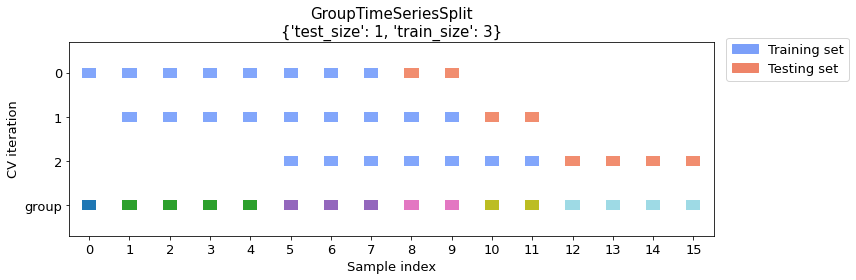

Train indices: [0 1 2 3 4 5 6 7]
Test indices: [8 9]
Train length: 8
Test length: 2
Train groups: [0 1 1 1 1 2 2 2]
Test groups: [3 3]
Train group size: 3
Test group size: 1
Train group months: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03'
 '2021-03']
Test group months: ['2021-04' '2021-04']

Train indices: [1 2 3 4 5 6 7 8 9]
Test indices: [10 11]
Train length: 9
Test length: 2
Train groups: [1 1 1 1 2 2 2 3 3]
Test groups: [4 4]
Train group size: 3
Test group size: 1
Train group months: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03'
 '2021-04' '2021-04']
Test group months: ['2021-05' '2021-05']

Train indices: [ 5  6  7  8  9 10 11]
Test indices: [12 13 14 15]
Train length: 7
Test length: 4
Train groups: [2 2 2 3 3 4 4]
Test groups: [5 5 5 5]
Train group size: 3
Test group size: 1
Train group months: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04' '2021-05' '2021-05']
Test group months: ['2021-06' '2021-06' '2021-06' '2021-06']



In [6]:
cv_args = {"test_size": 1, "train_size": 3}

plot_splits(X, y, groups, **cv_args)
print_split_info(X, y, groups, **cv_args)

Please note that if we specify the number of groups for both the training and the test set, the split size is determined automatically, and the number of splits naturally changes with the groups sizes. For example, increasing the number of training groups will naturally result in a lower number of splits as shown below.

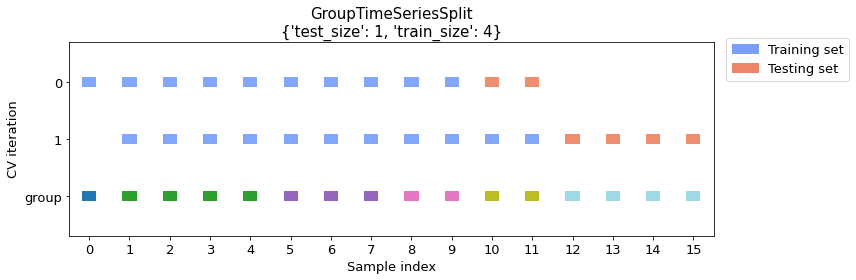

In [16]:
cv_args = {"test_size": 1, "train_size": 4}

plot_splits(X, y, groups, **cv_args)

### Usage in CV

The example below illustrates how we can use the time series splitter with scikit-learn, i.e., using `cross_val_score`:

In [7]:
cv = GroupTimeSeriesSplit(**cv_args)
clf = DummyClassifier(strategy="most_frequent")

scores = cross_val_score(clf, X, y, groups=groups, scoring="accuracy", cv=cv)
print_cv_info(cv, X, y, groups, clf, scores)

Split number: 1
Train true target: [1 0 1 0 1 0 0 1]
Train predicted target: [0 0 0 0 0 0 0 0]
Test true target: [1 1]
Test predicted target: [0 0]
Accuracy: 0.0

Split number: 2
Train true target: [0 1 0 1 0 0 1 1 1]
Train predicted target: [1 1 1 1 1 1 1 1 1]
Test true target: [0 1]
Test predicted target: [1 1]
Accuracy: 0.5

Split number: 3
Train true target: [0 0 1 1 1 0 1]
Train predicted target: [1 1 1 1 1 1 1]
Test true target: [1 0 0 0]
Test predicted target: [1 1 1 1]
Accuracy: 0.25



## Example 2 -- Multiple training groups (with number of splits specified)

Now let's take a look at an example where we don't specify the number of training groups. Here, we will split the dataset with test size (2 groups) and a specified number of splits (3 groups), which is sufficient for calculating the training size automatically.

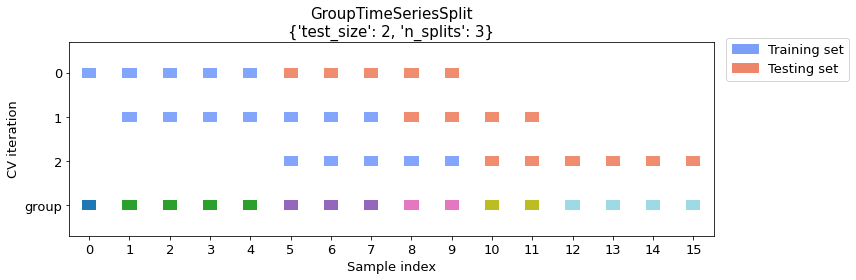

Train indices: [0 1 2 3 4]
Test indices: [5 6 7 8 9]
Train length: 5
Test length: 5
Train groups: [0 1 1 1 1]
Test groups: [2 2 2 3 3]
Train group size: 2
Test group size: 2
Train group months: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02']
Test group months: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04']

Train indices: [1 2 3 4 5 6 7]
Test indices: [ 8  9 10 11]
Train length: 7
Test length: 4
Train groups: [1 1 1 1 2 2 2]
Test groups: [3 3 4 4]
Train group size: 2
Test group size: 2
Train group months: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03']
Test group months: ['2021-04' '2021-04' '2021-05' '2021-05']

Train indices: [5 6 7 8 9]
Test indices: [10 11 12 13 14 15]
Train length: 5
Test length: 6
Train groups: [2 2 2 3 3]
Test groups: [4 4 5 5 5 5]
Train group size: 2
Test group size: 2
Train group months: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04']
Test group months: ['2021-05' '2021-05' '2021-06' '2021-06' '2021-06' '2021-06']



In [8]:
cv_args = {"test_size": 2, "n_splits": 3}

plot_splits(X, y, groups, **cv_args)
print_split_info(X, y, groups, **cv_args)

### Usage in CV

Again, let's take a look at how this looks in a scikit-learn context using `cross_val_score`:

In [9]:
cv = GroupTimeSeriesSplit(**cv_args)
clf = DummyClassifier(strategy="most_frequent")

scores = cross_val_score(clf, X, y, groups=groups, scoring="accuracy", cv=cv)
print_cv_info(cv, X, y, groups, clf, scores)

Split number: 1
Train true target: [1 0 1 0 1]
Train predicted target: [1 1 1 1 1]
Test true target: [0 0 1 1 1]
Test predicted target: [1 1 1 1 1]
Accuracy: 0.6

Split number: 2
Train true target: [0 1 0 1 0 0 1]
Train predicted target: [0 0 0 0 0 0 0]
Test true target: [1 1 0 1]
Test predicted target: [0 0 0 0]
Accuracy: 0.25

Split number: 3
Train true target: [0 0 1 1 1]
Train predicted target: [1 1 1 1 1]
Test true target: [0 1 1 0 0 0]
Test predicted target: [1 1 1 1 1 1]
Accuracy: 0.33



## Example 3 -- Defining the gap size between training and test datasets

`GroupTimeSeriesSplit` let's you specify a gap size greater than 1 in order to skip a specified number of groups between training and test folds (the default gap size is 0). In the example below, we use a gap of 1 group to illustrate this.

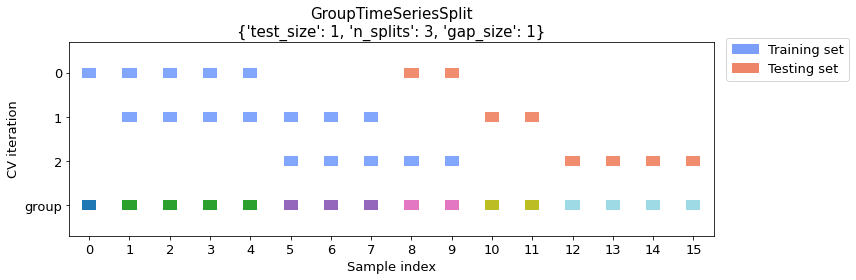

Train indices: [0 1 2 3 4]
Test indices: [8 9]
Train length: 5
Test length: 2
Train groups: [0 1 1 1 1]
Test groups: [3 3]
Train group size: 2
Test group size: 1
Train group months: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02']
Test group months: ['2021-04' '2021-04']

Train indices: [1 2 3 4 5 6 7]
Test indices: [10 11]
Train length: 7
Test length: 2
Train groups: [1 1 1 1 2 2 2]
Test groups: [4 4]
Train group size: 2
Test group size: 1
Train group months: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03']
Test group months: ['2021-05' '2021-05']

Train indices: [5 6 7 8 9]
Test indices: [12 13 14 15]
Train length: 5
Test length: 4
Train groups: [2 2 2 3 3]
Test groups: [5 5 5 5]
Train group size: 2
Test group size: 1
Train group months: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04']
Test group months: ['2021-06' '2021-06' '2021-06' '2021-06']



In [9]:
cv_args = {"test_size": 1, "n_splits": 3, "gap_size": 1}

plot_splits(X, y, groups, **cv_args)
print_split_info(X, y, groups, **cv_args)

### Usage in CV

The example below shows how this looks like in a scikit-learn context using `cross_val_score`:

In [10]:
cv = GroupTimeSeriesSplit(**cv_args)
clf = DummyClassifier(strategy="most_frequent")

scores = cross_val_score(clf, X, y, groups=groups, scoring="accuracy", cv=cv)
print_cv_info(cv, X, y, groups, clf, scores)

Split number: 1
Train true target: [1 0 1 0 1]
Train predicted target: [1 1 1 1 1]
Test true target: [1 1]
Test predicted target: [1 1]
Accuracy: 1.0

Split number: 2
Train true target: [0 1 0 1 0 0 1]
Train predicted target: [0 0 0 0 0 0 0]
Test true target: [0 1]
Test predicted target: [0 0]
Accuracy: 0.5

Split number: 3
Train true target: [0 0 1 1 1]
Train predicted target: [1 1 1 1 1]
Test true target: [1 0 0 0]
Test predicted target: [1 1 1 1]
Accuracy: 0.25



## API

In [14]:
with open("../../api_modules/mlxtend.evaluate/GroupTimeSeriesSplit.md", "r") as f:
    s = f.read()
print(s)

## GroupTimeSeriesSplit

*GroupTimeSeriesSplit(test_size, train_size=None, n_splits=None, gap_size=0, shift_size=1, window_type='rolling')*

Group time series cross-validator.

**Parameters**

- `test_size` : int

    Size of test dataset.

- `train_size` : int (default=None)

    Size of train dataset.

- `n_splits` : int (default=None)

    Number of the splits.

- `gap_size` : int (default=0)

    Gap size between train and test datasets.

- `shift_size` : int (default=1)

    Step to shift for the next fold.

- `window_type` : str (default="rolling")

    Type of the window. Possible values: "rolling", "expanding".

**Examples**

For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/evaluate/GroupTimeSeriesSplit/

### Methods

<hr>

*get_n_splits(X=None, y=None, groups=None)*

Returns the number of splitting iterations in the cross-validator.

**Parameters**

- `X` : object

    Always ignored, exists for compatibility.

- `y` : object

    Always ignored, ex